# Electricity Price Forecasting with LSTM

This notebook implements an LSTM-based model for forecasting electricity prices. The model uses historical price data along with various features to predict prices for the next 24 hours.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers.legacy import Adam
import os
import pickle
import gc  # Add garbage collector

# 1. Data Loading and Preprocessing

In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import logging

class EnerginetDataFetcher:
    """Class to fetch electricity price data from Energinet's API"""
    
    def __init__(self):
        self.base_url = "https://api.energidataservice.dk/dataset/Elspotprices"
        self.setup_logging()
    
    def setup_logging(self):
        """Setup logging configuration"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
    
    def fetch_elspot_prices(self, start_date=None, end_date=None, price_area='SE4'):
        """
        Fetch electricity spot prices from Energinet's API
        
        Args:
            start_date (str): Start date in format 'YYYY-MM-DD'
            end_date (str): End date in format 'YYYY-MM-DD'
            price_area (str): Price area (e.g., 'DK1', 'DK2')
        
        Returns:
            pd.DataFrame: DataFrame containing the spot prices
        """
        try:
            # Construct the query parameters
            params = {
                'limit': 100000,  # Maximum limit to get all data
                'filter': f'{{"PriceArea": "{price_area}"}}'
            }
            
            if start_date and end_date:
                params['start'] = start_date
                params['end'] = end_date
            
            # Make the API request
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()  # Raise an exception for bad status codes
            
            # Parse the response
            result = response.json()
            
            if not result.get('records'):
                self.logger.warning("No data found for the specified parameters")
                return pd.DataFrame()
            
            # Convert records to DataFrame
            df = pd.DataFrame(result['records'])
            
            # Convert timestamp to datetime
            df['HourUTC'] = pd.to_datetime(df['HourUTC'])
            
            # Sort by timestamp
            df = df.sort_values('HourUTC')
            
            return df
            
        except requests.exceptions.RequestException as e:
            self.logger.error(f"Error fetching data: {str(e)}")
            return pd.DataFrame()
        except Exception as e:
            self.logger.error(f"Unexpected error: {str(e)}")
            return pd.DataFrame()
    
    def fetch_historical_data(self, days=30, price_area='SE4'):
        """
        Fetch historical electricity spot prices
        
        Args:
            days (int): Number of days of historical data to fetch
            price_area (str): Price area (e.g., 'DK1', 'DK2')
        
        Returns:
            pd.DataFrame: DataFrame containing the historical spot prices
        """
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        
        return self.fetch_elspot_prices(
            start_date=start_date.strftime('%Y-%m-%d'),
            end_date=end_date.strftime('%Y-%m-%d'),
            price_area=price_area
        )


In [7]:
def fetch_and_prepare_data(n_years=5):
    """Fetch and prepare data for analysis"""
    print("Fetching data from Energinet...")
    fetcher = EnerginetDataFetcher()
    df = fetcher.fetch_historical_data(days=365*n_years)
    df = df[['HourUTC','SpotPriceDKK']]
    df.sort_index(inplace=True)

    print("\nDataset Info:")
    print(df.info())
    print("\nSample of the data:")
    print(df.head())
    print("\nData Statistics:")
    print(df['SpotPriceDKK'].describe())
    
    return df

# Fetch the data
df = fetch_and_prepare_data(n_years=5)

# Display data coverage
print("\nData Coverage:")
print(f"Date Range: {df['HourUTC'].min()} to {df['HourUTC'].max()}")
print(f"Total Hours: {len(df)}")


Fetching data from Energinet...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 0 to 43799
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   HourUTC       43800 non-null  datetime64[ns]
 1   SpotPriceDKK  43800 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB
None

Sample of the data:
              HourUTC  SpotPriceDKK
0 2025-04-02 21:00:00    495.715499
1 2025-04-02 20:00:00    512.428348
2 2025-04-02 19:00:00    527.723625
3 2025-04-02 18:00:00    594.351256
4 2025-04-02 17:00:00    843.551951

Data Statistics:
count    43800.000000
mean       574.569011
std        651.433014
min       -447.459991
25%        161.577503
50%        385.559998
75%        743.424988
max       5950.569824
Name: SpotPriceDKK, dtype: float64

Data Coverage:
Date Range: 2020-04-03 22:00:00 to 2025-04-02 21:00:00
Total Hours: 43800


## Data Quality Check

Let's examine the data quality and identify any potential issues.

In [27]:
import sns
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check for duplicates
print("\nDuplicate Timestamps:")
print(df[df.duplicated(subset=['HourUTC'], keep=False)])

# Check for outliers
Q1 = df['SpotPriceDKK'].quantile(0.25)
Q3 = df['SpotPriceDKK'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['SpotPriceDKK'] < (Q1 - 1.5 * IQR)) | (df['SpotPriceDKK'] > (Q3 + 1.5 * IQR))]
print("\nPotential Outliers:")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier percentage: {(len(outliers) / len(df)) * 100:.2f}%")

# Plot price distribution with outliers highlighted
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, y='SpotPriceDKK')
plt.title('Price Distribution with Outliers')
plt.ylabel('Price (DKK)')
plt.tight_layout()
plt.savefig('price_distribution_with_outliers.png')
plt.show()

ModuleNotFoundError: No module named 'sns'

In [ ]:
def exploratory_data_analysis(df):
    """Perform exploratory data analysis"""
    print("\nPerforming exploratory data analysis...")
    
    # 1. Price distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='SpotPriceDKK', bins=50)
    plt.title('Distribution of Electricity Prices')
    plt.xlabel('Price (DKK)')
    plt.ylabel('Count')
    plt.savefig('price_distribution.png')
    plt.close()
    
    # 2. Price over time
    plt.figure(figsize=(15, 6))
    plt.plot(df['HourUTC'], df['SpotPriceDKK'])
    plt.title('Electricity Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('Price (DKK)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('price_over_time.png')
    plt.close()
    
    # 3. Average price by hour of day
    hourly_avg = df.groupby('hour')['SpotPriceDKK'].mean()
    plt.figure(figsize=(12, 6))
    hourly_avg.plot(kind='bar')
    plt.title('Average Price by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Price (DKK)')
    plt.tight_layout()
    plt.savefig('hourly_average.png')
    plt.close()
    
    # 4. Price patterns by day of week
    daily_avg = df.groupby('day_of_week')['SpotPriceDKK'].mean()
    plt.figure(figsize=(12, 6))
    daily_avg.plot(kind='bar')
    plt.title('Average Price by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Price (DKK)')
    plt.tight_layout()
    plt.savefig('daily_average.png')
    plt.close()
    
    # 5. Monthly price patterns
    monthly_avg = df.groupby('month')['SpotPriceDKK'].mean()
    plt.figure(figsize=(12, 6))
    monthly_avg.plot(kind='bar')
    plt.title('Average Price by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Price (DKK)')
    plt.tight_layout()
    plt.savefig('monthly_average.png')
    plt.close()

# Perform EDA
exploratory_data_analysis(df)


Performing exploratory data analysis...


AttributeError: module 'matplotlib.pyplot' has no attribute 'histplot'

<Figure size 1000x600 with 0 Axes>

## Load And Preprocess Data

In [18]:
# 1. Data Preprocessing
def preprocess_data(df):
    """
    Load and preprocess the electricity price data
    """

    # Rename columns if they have spaces or special characters
    df.columns = [col.strip() for col in df.columns]
    
    # Convert HourUTC to datetime and set as index
    df['HourUTC'] = pd.to_datetime(df['HourUTC'])
    df = df.set_index('HourUTC')
    
    # Sort by datetime
    df = df.sort_index()
    
    # Check for and handle any missing values
    if df.isnull().sum().sum() > 0:
        df = df.interpolate(method='time')
    
    # Add time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['is_weekend'] = df.index.dayofweek >= 5
    
    return df

df = preprocess_data(df)

## Create Features

In [11]:
# 2. Feature Engineering and Sequence Creation
def create_features(df, price_col, forecast_horizon):
    """
    Create features for the model, ensuring proper time boundaries
    
    Args:
        df: DataFrame with price data
        price_col: Column name for the price
        forecast_horizon: Number of hours ahead to forecast
    """
    df = df.copy()
    
    # Create lagged features (only using past data)
    for lag in [24, 48, 72, 168]:  # 1 day, 2 days, 3 days, 1 week
        df[f'price_lag_{lag}h'] = df[price_col].shift(lag)
    
    # Create rolling statistics (only using past data)
    for window in [24, 168]:
        df[f'price_mean_{window}h'] = df[price_col].rolling(window).mean().shift(1)
        df[f'price_std_{window}h'] = df[price_col].rolling(window).std().shift(1)
        df[f'price_max_{window}h'] = df[price_col].rolling(window).max().shift(1)
        df[f'price_min_{window}h'] = df[price_col].rolling(window).min().shift(1)
    
    return df

## Create Sequences

In [12]:
def create_sequences(df, feature_columns, target_columns, lookback):
    """
    Create sequences for LSTM model
    
    Args:
        df: DataFrame with features and targets
        feature_columns: List of feature column names
        target_columns: List of target column names
        lookback: Number of historical hours to use
    """
    X, y = [], []
    for i in range(len(df) - lookback + 1):
        X.append(df[feature_columns].iloc[i:i+lookback].values)
        y.append(df[target_columns].iloc[i+lookback-1].values)
    
    return np.array(X), np.array(y)



## Prepare Lstm Data

In [15]:
# 2. Feature Engineering and Sequence Creation
def prepare_lstm_data(df, price_col='SpotPriceDKK', lookback=168, forecast_horizon=24, 
                     train_size=0.7, val_size=0.15, test_size=0.15):
    """
    Prepare data for LSTM model with a specified lookback period
    
    Args:
        df: DataFrame with price data
        price_col: Column name for the price
        lookback: Number of historical hourly prices to use (168 = 1 week)
        forecast_horizon: Number of hours ahead to forecast (24 = 1 day)
        train_size: Proportion of data to use for training
        val_size: Proportion of data to use for validation
        test_size: Proportion of data to use for testing
        data_dir: Directory to save/load the processed data
    """
    # First, split the data into training, validation, and testing sets based on time
    # This ensures we don't have any future data leakage into the training set
    train_end_idx = int(len(df) * train_size)
    val_end_idx = int(len(df) * (train_size + val_size))
    
    train_df = df.iloc[:train_end_idx].copy()
    val_df = df.iloc[train_end_idx:val_end_idx].copy()
    test_df = df.iloc[val_end_idx:].copy()
    
    print(f"Training set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    # Create feature columns for training data
    train_df = create_features(train_df, price_col, forecast_horizon)
    
    # Create feature columns for validation and test data (using only past data)
    val_df = create_features(val_df, price_col, forecast_horizon)
    test_df = create_features(test_df, price_col, forecast_horizon)
    
    # Create target columns for all sets
    for i in range(1, forecast_horizon + 1):
        train_df[f'target_{i}h'] = train_df[price_col].shift(-i)
        val_df[f'target_{i}h'] = val_df[price_col].shift(-i)
        test_df[f'target_{i}h'] = test_df[price_col].shift(-i)
    
    # Drop rows with NaNs
    train_df = train_df.dropna()
    val_df = val_df.dropna()
    test_df = test_df.dropna()
    
    # Separate features and target
    feature_columns = [col for col in train_df.columns if not col.startswith('target_') and col != price_col]
    target_columns = [f'target_{i}h' for i in range(1, forecast_horizon + 1)]
    print ('feature_columns: ', feature_columns)
    print ('target_columns: ', target_columns)

    # Scale features using only training data
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    train_df[feature_columns] = feature_scaler.fit_transform(train_df[feature_columns])
    val_df[feature_columns] = feature_scaler.transform(val_df[feature_columns])
    test_df[feature_columns] = feature_scaler.transform(test_df[feature_columns])
    
    # Scale targets using only training data
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    train_df[target_columns] = target_scaler.fit_transform(train_df[target_columns])
    val_df[target_columns] = target_scaler.transform(val_df[target_columns])
    test_df[target_columns] = target_scaler.transform(test_df[target_columns])
    
    # Create sequences for training data
    X_train, y_train = create_sequences(train_df, feature_columns, target_columns, lookback)
    
    # Create sequences for validation data
    X_val, y_val = create_sequences(val_df, feature_columns, target_columns, lookback)
    
    # Create sequences for testing data
    X_test, y_test = create_sequences(test_df, feature_columns, target_columns, lookback)
    

    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler, train_df, val_df, test_df

In [19]:
df.head()

,SpotPriceDKK,hour,day_of_week,month,year,is_weekend
HourUTC,,,,,,
2020-04-03 22:00:00,33.009998,22,4,4,2020,False
2020-04-03 23:00:00,32.939999,23,4,4,2020,False
2020-04-04 00:00:00,32.720001,0,5,4,2020,True
2020-04-04 01:00:00,32.860001,1,5,4,2020,True
2020-04-04 02:00:00,33.240002,2,5,4,2020,True


In [20]:
print("Preparing data for LSTM...")
X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler, train_df, val_df, test_df = prepare_lstm_data(
    df, price_col='SpotPriceDKK')

Preparing data for LSTM...
Training set: 30659 samples
Validation set: 6571 samples
Test set: 6570 samples
feature_columns:  ['hour', 'day_of_week', 'month', 'year', 'is_weekend', 'price_lag_24h', 'price_lag_48h', 'price_lag_72h', 'price_lag_168h', 'price_mean_24h', 'price_std_24h', 'price_max_24h', 'price_min_24h', 'price_mean_168h', 'price_std_168h', 'price_max_168h', 'price_min_168h']
target_columns:  ['target_1h', 'target_2h', 'target_3h', 'target_4h', 'target_5h', 'target_6h', 'target_7h', 'target_8h', 'target_9h', 'target_10h', 'target_11h', 'target_12h', 'target_13h', 'target_14h', 'target_15h', 'target_16h', 'target_17h', 'target_18h', 'target_19h', 'target_20h', 'target_21h', 'target_22h', 'target_23h', 'target_24h']


## Build Lstm Model

In [30]:
# 3. Model Building
def build_lstm_model(lookback, n_features, n_outputs=24):
    """
    Build LSTM model for time series forecasting
    """
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(lookback, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs))

    optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse')
    return model



In [31]:
# Custom callback to track original MSE and MAE
class OriginalMetricsCallback(Callback):
    def __init__(self, target_scaler, X_train, y_train, X_val, y_val):
        super(OriginalMetricsCallback, self).__init__()
        self.target_scaler = target_scaler
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.train_original_mse = []
        self.train_original_mae = []
        self.val_original_mse = []
        self.val_original_mae = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions for validation data
        y_val_pred = self.model.predict(self.X_val, verbose=0)
        
        # Inverse transform validation predictions and actual values
        y_val_pred_original = self.target_scaler.inverse_transform(y_val_pred)
        y_val_original = self.target_scaler.inverse_transform(self.y_val)
        
        # Calculate original MSE and MAE for validation data
        val_mse = np.mean(np.square(y_val_original - y_val_pred_original))
        val_mae = np.mean(np.abs(y_val_original - y_val_pred_original))
        
        # Store validation metrics
        self.val_original_mse.append(val_mse)
        self.val_original_mae.append(val_mae)
        
        # Get predictions for training data
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        
        # Inverse transform training predictions and actual values
        y_train_pred_original = self.target_scaler.inverse_transform(y_train_pred)
        y_train_original = self.target_scaler.inverse_transform(self.y_train)
        
        # Calculate original MSE and MAE for training data
        train_mse = np.mean(np.square(y_train_original - y_train_pred_original))
        train_mae = np.mean(np.abs(y_train_original - y_train_pred_original))
        
        # Store training metrics
        self.train_original_mse.append(train_mse)
        self.train_original_mae.append(train_mae)
        
        # Add to logs
        logs['train_original_mse'] = train_mse
        logs['train_original_mae'] = train_mae
        logs['val_original_mse'] = val_mse
        logs['val_original_mae'] = val_mae


In [32]:
def lr_schedule(epoch, initial_lr=0.01, decay_factor=0.5, decay_epochs=10):
    """
    Learning rate scheduler function that reduces the learning rate by a factor
    after a certain number of epochs.
    
    Args:
        epoch: Current epoch number
        initial_lr: Initial learning rate
        decay_factor: Factor by which to reduce the learning rate
        decay_epochs: Number of epochs after which to reduce the learning rate
        
    Returns:
        Learning rate for the current epoch
    """
    if epoch % decay_epochs == 0 and epoch > 0:
        return initial_lr * (decay_factor ** (epoch // decay_epochs))
    return initial_lr

# 4. Training and Evaluation

## Train And Evaluate Model

In [33]:
# 4. Training and Evaluation
def train_and_evaluate_model(X_train, X_val, y_train, y_val, epochs=100, batch_size=32, target_scaler=None):
    """
    Train and evaluate LSTM model
    
    Args:
        X_train: Training features
        X_val: Validation features
        y_train: Training targets
        y_val: Validation targets
        epochs: Number of training epochs
        batch_size: Batch size for training
        target_scaler: Scaler used for target values (for original metrics calculation)
    """
    # Build model
    model = build_lstm_model(X_train.shape[1], X_train.shape[2], y_train.shape[1])
    
    # Create custom callback for original metrics if target_scaler is provided
    callbacks = []
    
    # Early stopping - use val_original_mae if target_scaler is provided, otherwise use val_loss
    if target_scaler is not None:
        # Create the original metrics callback first
        original_metrics_callback = OriginalMetricsCallback(
            target_scaler, 
            X_train, 
            y_train, 
            X_val, 
            y_val
        )
        callbacks.append(original_metrics_callback)
        
        # Early stopping on original MAE
        early_stopping = EarlyStopping(
            monitor='val_original_mae',
            patience=15,
            restore_best_weights=True,
            mode='min'
        )
        
        # Reduce learning rate on plateau
        reduce_lr = ReduceLROnPlateau(
            monitor='val_original_mae',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            mode='min',
            verbose=1
        )
    else:
        # Early stopping on validation loss
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
        
        # Reduce learning rate on plateau
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    
    # Learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
    
    # Add callbacks
    callbacks.append(early_stopping)
    callbacks.append(reduce_lr)
    callbacks.append(lr_scheduler)
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate original metrics if target_scaler is provided
    if target_scaler is not None:
        # Inverse transform predictions and actual values
        y_train_pred_original = target_scaler.inverse_transform(y_train_pred)
        y_train_original = target_scaler.inverse_transform(y_train)
        y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
        y_val_original = target_scaler.inverse_transform(y_val)
        
        # Calculate original MSE and MAE
        train_mse_original = np.mean(np.square(y_train_original - y_train_pred_original))
        train_mae_original = np.mean(np.abs(y_train_original - y_train_pred_original))
        val_mse_original = np.mean(np.square(y_val_original - y_val_pred_original))
        val_mae_original = np.mean(np.abs(y_val_original - y_val_pred_original))
        
        print(f'Train Original MSE: {train_mse_original:.4f}, Train Original MAE: {train_mae_original:.4f}')
        print(f'Validation Original MSE: {val_mse_original:.4f}, Validation Original MAE: {val_mae_original:.4f}')
        
        # Plot original metrics during training
        plt.figure(figsize=(12, 10))
        
        # Plot original MSE
        plt.subplot(2, 2, 1)
        plt.plot(original_metrics_callback.train_original_mse, label='Training Original MSE')
        plt.plot(original_metrics_callback.val_original_mse, label='Validation Original MSE')
        plt.title('Original MSE During Training')
        plt.ylabel('Mean Squared Error')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        
        # Plot original MAE
        plt.subplot(2, 2, 2)
        plt.plot(original_metrics_callback.train_original_mae, label='Training Original MAE')
        plt.plot(original_metrics_callback.val_original_mae, label='Validation Original MAE')
        plt.title('Original MAE During Training')
        plt.ylabel('Mean Absolute Error')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        
        plt.show()
    
    return model, history, y_train_pred, y_val_pred


In [ ]:
# 3. Train and evaluate model
print("Training and evaluating model...")
model, history, y_train_pred, y_val_pred = train_and_evaluate_model(X_train, X_val, y_train, y_val, epochs=2, target_scaler=target_scaler)


Training and evaluating model...

Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/2
947/947 [==============================] - ETA: 0s - loss: 0.0224

## Evaluate On Test Set

In [41]:
def evaluate_on_test_set(model, X_test, y_test, target_scaler):
    """
    Evaluate the model on the test set
    
    Args:
        model: Trained LSTM model
        X_test: Test features
        y_test: Test targets
        target_scaler: Scaler used for target values
        price_col: Column name for the price
        save_path: Path to save the plots
    """
    # Make predictions on test set in batches
    y_test_pred = []
    batch_size = 1000
    
    for i in range(0, len(X_test), batch_size):
        end_idx = min(i + batch_size, len(X_test))
        y_test_pred_batch = model.predict(X_test[i:end_idx], verbose=0)
        y_test_pred.append(y_test_pred_batch)
        
        # Free up memory
        del y_test_pred_batch
        gc.collect()
    
    y_test_pred = np.concatenate(y_test_pred, axis=0)
    
    # Inverse transform predictions and actual values
    y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
    y_test_original = target_scaler.inverse_transform(y_test)
    
    # Calculate original MSE and MAE
    test_mse_original = np.mean(np.square(y_test_original - y_test_pred_original))
    test_mae_original = np.mean(np.abs(y_test_original - y_test_pred_original))
    
    print(f'Test Original MSE: {test_mse_original:.4f}, Test Original MAE: {test_mae_original:.4f}')
        
    
    return y_test_pred, test_mse_original, test_mae_original

In [43]:
y_test_pred, test_mse_original, test_mae_original = evaluate_on_test_set(model, X_test, y_test, target_scaler)

Test Original MSE: 587625.4825, Test Original MAE: 606.1553


## Generate Day Ahead Forecast

In [63]:
def generate_day_ahead_forecast(model, test_df, target_scaler, price_col='SpotPriceDKK'):
    """
    Generate forecasts for the next 24 hours
    
    Parameters:
    model: Trained LSTM model
    test_df: test dataframe
    target_scaler: Scaler used for targets
    price_col: Column name for price data
    """
    
    feature_columns = [col for col in test_df.columns if not col.startswith('target_') and col != price_col]
    latest_data = test_df[feature_columns].iloc[-168:].values

    # Get the last known timestamp from the test dataframe
    last_known_timestamp = test_df.index[-1]

    
    # Prepare the input data (already scaled)
    input_data = latest_data.reshape(1, latest_data.shape[0], latest_data.shape[1])
    
    # Generate prediction
    prediction_scaled = model.predict(input_data, verbose=0)
    
    # Inverse transform
    prediction = target_scaler.inverse_transform(prediction_scaled)[0]
    
    # Create timestamp for the next 24 hours
    forecast_hours = [last_known_timestamp + timedelta(hours=i+1) for i in range(24)]
    
    # Create forecast dataframe
    forecast_df = pd.DataFrame({
        'HourUTC': forecast_hours,
        f'Forecast_{price_col}': prediction
    })
    forecast_df.set_index('HourUTC', inplace=True)
    
    # Generate baseline forecasts
    # 1. Mean baseline
    mean_price = test_df[price_col].mean()
    mean_forecast = np.full(24, mean_price)
    
    # 2. Naive baseline (use the last known price)
    naive_forecast = np.full(24, test_df[price_col].iloc[-1])
    
    # 3. Persistence baseline (use the last known price for the next hour)
    persistence_forecast = test_df[price_col].iloc[-191:-167].values
    
    # Add baseline forecasts to the dataframe
    forecast_df[f'Mean_Baseline'] = mean_forecast
    forecast_df[f'Naive_Baseline'] = naive_forecast
    forecast_df[f'Persistence_Baseline'] = persistence_forecast
    return forecast_df



forecast_df = generate_day_ahead_forecast(
model, test_df, target_scaler
)
    




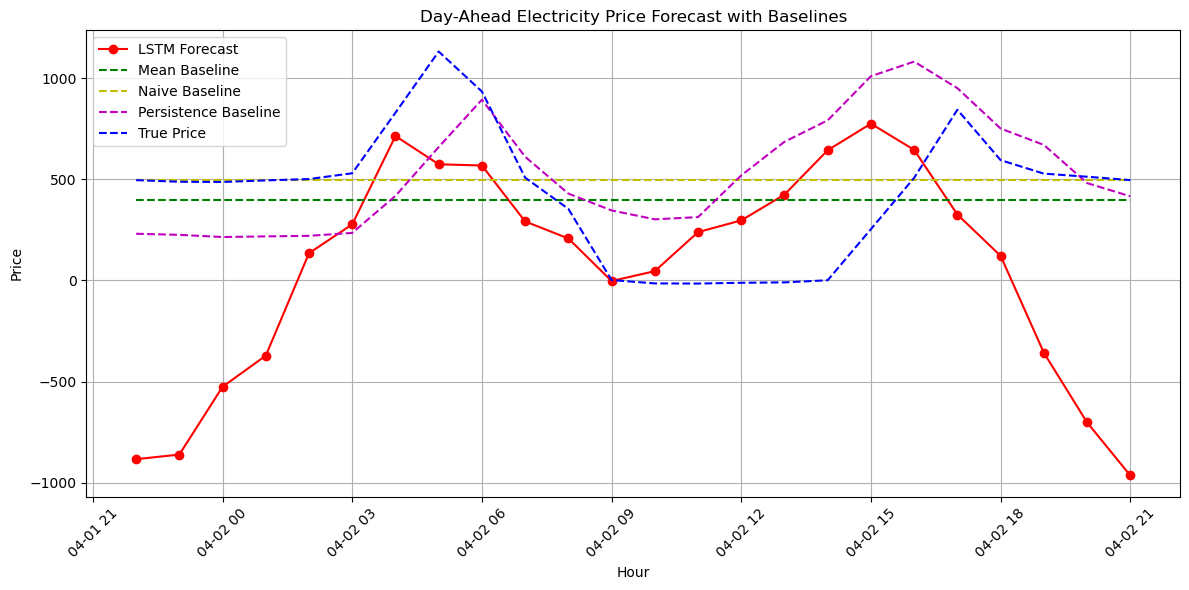

In [64]:
# Plot forecast with baselines
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df[f'Forecast_SpotPriceDKK'], 'r-o', label='LSTM Forecast')
plt.plot(forecast_df.index, forecast_df['Mean_Baseline'], 'g--', label='Mean Baseline')
plt.plot(forecast_df.index, forecast_df['Naive_Baseline'], 'y--', label='Naive Baseline')
plt.plot(forecast_df.index, forecast_df['Persistence_Baseline'], 'm--', label='Persistence Baseline')
plt.plot(forecast_df.index, df['SpotPriceDKK'].iloc[-24:].values, 'b--', label='True Price')

plt.title('Day-Ahead Electricity Price Forecast with Baselines')
plt.xlabel('Hour')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()